In [1]:
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 60)
pd.set_option('display.max_rows', 60)
pd.set_option('mode.chained_assignment',  None)

plt.rc('font',family='malgun gothic')

# 국가교통 데이터 오픈마켓
bus_info_data_by_day = pd.read_csv('./data/대전시_버스_일일_정보_데이터.csv', sep = "|") # 대전시 버스 일일 정보 데이터
bus_speed_data = pd.read_csv('./data/대전시_버스_통행_속도_데이터.csv', sep = "|") # 대전시 버스 통행 속도 데이터
bus_route_statistic_data = pd.read_csv('./data/대전시_버스_노선_운행_통계_데이터.csv', sep = "|") # 대전시 버스 노선 운행 통계 데이터
bus_card_data = pd.read_csv('./data/대전시_버스_교통카드거래_이력_데이터.csv', sep = "|") # 대전시 버스 카드 거래 이력 데이터
speed_comparison_data = pd.read_csv('./data/대전시_버스전용차로_승용차구간_속도비교_데이터.csv', sep = "|") # 대전시 버스전용차로 승용차구간 속도비교 데이터

bus_info_data_by_day.drop(labels = ['ETL_TYPE','ETL_DATE'], axis =  1, inplace = True)
bus_speed_data.drop(labels = ['ETL_TYPE','ETL_DATE'], axis =  1, inplace = True)
bus_route_statistic_data.drop(labels = ['ETL_TYPE','ETL_DATE'], axis =  1, inplace = True)
bus_card_data.drop(labels = ['ETL_TYPE','ETL_DATE'], axis =  1, inplace = True)

# 대전 교통 빅데이터 플랫폼
route_curve = pd.read_csv('./data/route_curve.csv', encoding = 'cp949')
route_curve = route_curve.iloc[:,:5]

# 공공데이터포털
getrouteinfoall = pd.read_csv('./data/getRouteInfoAll.csv', encoding = 'cp949', index_col = 0) # 전체 노선 기본정보 조회
getstationbyrouteall = pd.read_csv('./data/getStationByRouteAll.csv', encoding = 'cp949', index_col = 0) # 전체노선별경유정류소 정보 조회

# 정류장 데이터
bus_sttn = pd.read_csv('./data/bus_sttn.csv')

# 스마트카드 데이터
smart_card_data = pd.read_csv('./data/smart_card_data.csv')

In [2]:
def smart_card_preprocessing(exdata): # 스마트카드 데이터 전처리
    exdata = exdata[exdata['GETOFF_BUS_STTN_ID']!='~      '] # 하차 태그 없는 데이터 제거
    exdata['GETON_TM'] = exdata['GETON_TM'].apply(lambda x: str(x).zfill(6)) # GETON_TM 컬럼 날짜형식으로 변환하기 위해 자릿수 맞춰주기
    
    # datetime 형식으로 변환 및 새로운 column 생성
    exdata['GETON_DATETIME'] = pd.to_datetime(exdata['GETON_YMD'].astype(str) + exdata['GETON_TM'].astype(str), format = '%Y%m%d%H%M%S')
    exdata['GETOFF_DATETIME'] = pd.to_datetime(exdata['GETOFF_YMD'].astype(str) + exdata['GETOFF_TM'].astype(str), format = '%Y%m%d%H%M%S', errors = 'coerce')
    
    # 여러명이 탄 경우 제거
    exdata = exdata[exdata['YSR_CNT']==1]
    
    # 지선, 간선 버스만 필터링
    exdata = exdata[exdata['TR_MEANS_TYPE'].isin([676, 675])]
    
    # 사용한 행 제거
    exdata.drop(labels = ['GETON_YMD','GETON_TM','GETOFF_YMD','GETOFF_TM'], axis = 1, inplace = True)
    # 필요없는 행 제거
    exdata.drop(labels = ['SERIAL_NO', 'DRVN_START_YMD','DRVN_START_TM','DRVR_ID','GETON_CALC_YMD','GETOFF_CALC_YMD','ETL_TYPE','ETL_DATE'], axis = 1, inplace = True)
    exdata['DAY'] = exdata['GETON_DATETIME'].dt.day

    return exdata

In [3]:
def time_graph_large(exdata, getrouteinfoall ,time):
    exdata = exdata[exdata['GETON_TIME']==time]
    exdata.drop(labels= ['TRANSACTION_ID', 'TR_MEANS_TYPE', 'TRANSF_CNT','USR_TYPE','YSR_CNT','GETON_PAY','GETOFF_PAY','GETON_TIME'], axis = 1, inplace = True)
    exdata = exdata[['CARD_NO','BUS_ROUTE_ID','BUS_CO_ID','BUS_CAR_ID','GETON_BUS_STTN_ID','GETON_DATETIME','GETOFF_BUS_STTN_ID','GETOFF_DATETIME']]
    
    # getrouteinfoall
    getrouteinfoall_df = getrouteinfoall[['ROUTE_CD','ROUTE_NO']]
    exdata = exdata.merge(getrouteinfoall_df, left_on = 'BUS_ROUTE_ID', right_on = 'ROUTE_CD')
    exdata.drop(labels = ['ROUTE_CD'], axis = 1, inplace = True)
    
    # bus_route_id 별 이용량 계산
    bus_route_counts = exdata.groupby('ROUTE_NO').size()
    
    # 상위 10개 선택
    top_10_routes = bus_route_counts.nlargest(10)
    
    # 그래프 그리기
    plt.figure(figsize=(10, 6))
    top_10_routes.plot(kind='bar', color='mediumseagreen')
    plt.xlabel('ROUTE_NO')
    plt.ylabel('이용량')
    plt.title('상위 10개 버스 노선 별 이용량 그래프')
    plt.xticks(rotation=0)
    plt.grid(True, axis = 'y')
    plt.show()

def time_graph_small(exdata, getrouteinfoall ,time):
    exdata = exdata[exdata['GETON_TIME']==time]
    exdata.drop(labels= ['TRANSACTION_ID', 'TR_MEANS_TYPE', 'TRANSF_CNT','USR_TYPE','YSR_CNT','GETON_PAY','GETOFF_PAY','GETON_TIME'], axis = 1, inplace = True)
    exdata = exdata[['CARD_NO','BUS_ROUTE_ID','BUS_CO_ID','BUS_CAR_ID','GETON_BUS_STTN_ID','GETON_DATETIME','GETOFF_BUS_STTN_ID','GETOFF_DATETIME']]
    
    # getrouteinfoall
    getrouteinfoall_df = getrouteinfoall[['ROUTE_CD','ROUTE_NO']]
    exdata = exdata.merge(getrouteinfoall_df, left_on = 'BUS_ROUTE_ID', right_on = 'ROUTE_CD')
    exdata.drop(labels = ['ROUTE_CD'], axis = 1, inplace = True)
    
    # bus_route_id 별 이용량 계산
    bus_route_counts = exdata.groupby('ROUTE_NO').size()
    
    # 상위 10개 선택
    top_10_routes = bus_route_counts.nsmallest(10)
    
    # 그래프 그리기
    plt.figure(figsize=(10, 6))
    top_10_routes.plot(kind='bar', color='mediumseagreen')
    plt.xlabel('ROUTE_NO')
    plt.ylabel('이용량')
    plt.title('하위 10개 버스 노선 별 이용량 그래프')
    plt.xticks(rotation=0)
    plt.grid(True, axis = 'y')
    plt.show()


def time_graph(exdata, getrouteinfoall ,time):
    exdata = exdata[exdata['GETON_TIME']==time]
    exdata.drop(labels= ['TRANSACTION_ID', 'TR_MEANS_TYPE', 'TRANSF_CNT','USR_TYPE','YSR_CNT','GETON_PAY','GETOFF_PAY','GETON_TIME'], axis = 1, inplace = True)
    exdata = exdata[['CARD_NO','BUS_ROUTE_ID','BUS_CO_ID','BUS_CAR_ID','GETON_BUS_STTN_ID','GETON_DATETIME','GETOFF_BUS_STTN_ID','GETOFF_DATETIME']]
    
    # getrouteinfoall
    getrouteinfoall_df = getrouteinfoall[['ROUTE_CD','ROUTE_NO']]
    exdata = exdata.merge(getrouteinfoall_df, left_on = 'BUS_ROUTE_ID', right_on = 'ROUTE_CD')
    exdata.drop(labels = ['ROUTE_CD'], axis = 1, inplace = True)
    
    # bus_route_id 별 이용량 계산
    bus_route_counts = exdata.groupby('ROUTE_NO').size()
    
    # 상위 10개 선택
    top_10_routes = bus_route_counts.nlargest(10)
    
    # 버스번호에 따른 색상 매핑
    colors = {'102': 'red', '311': 'orange', '201': 'yellow', '301': 'green', '105': 'blue','106': 'purple', '703': 'pink', 
              '314': 'lightcoral', '103': 'sandybrown', '605': 'beige', '704' : 'palegreen','603':'lightskyblue','705':'mediumslateblue'}
    
    # 그래프 그리기
    plt.figure(figsize=(10, 6))
    top_10_routes.plot(kind='bar',color=[colors.get(route, 'mediumseagreen') for route in top_10_routes.index])
    plt.xlabel('ROUTE_NO')
    plt.ylabel('이용량')
    plt.title('상위 10개 버스 노선 별 이용량 그래프')
    plt.xticks(rotation=0)
    plt.grid(True, axis = 'y')
    plt.show()

In [4]:
df = smart_card_data.copy()
df = smart_card_preprocessing(df)

In [22]:
df_0425 = df[df['DAY']==25]
df_0425.drop(labels = ['DAY'], axis = 1, inplace = True)
df_0425['GETON_TIME'] = df_0425['GETON_DATETIME'].dt.hour
df_0425['GETOFF_TIME'] = df_0425['GETOFF_DATETIME'].dt.hour
display(df_0425.head(3))
print(df_0425.shape)

,CARD_NO,TRANSACTION_ID,TR_MEANS_TYPE,TRANSF_CNT,BUS_ROUTE_ID,BUS_CO_ID,BUS_CAR_ID,USR_TYPE,GETON_BUS_STTN_ID,GETOFF_BUS_STTN_ID,YSR_CNT,GETON_PAY,GETOFF_PAY,GETON_DATETIME,GETOFF_DATETIME,GETON_TIME,GETOFF_TIME
169539,734471053,6,675,0,30300059,130010004,130752270,1,8006006,8001930,1,1250,0,2022-04-25 19:19:47,2022-04-25 19:38:02,19,19
169540,661607970,8,676,0,30300070,130010004,130752603,1,8002794,8002155,1,1250,0,2022-04-25 07:53:58,2022-04-25 08:16:20,7,8
169541,706749254,19,675,0,30300079,130010009,130759123,1,8001721,8002802,1,1250,0,2022-04-25 08:07:51,2022-04-25 08:39:44,8,8


(276952, 17)


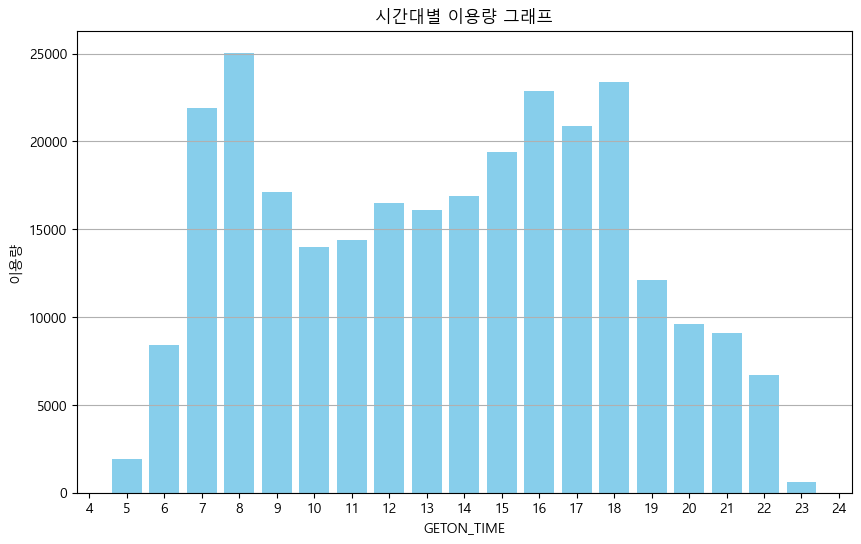

In [33]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# GETON_TIME별 이용량 계산
geton_time_counts = df_0425['GETON_TIME'].value_counts().sort_index()

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.bar(geton_time_counts.index, geton_time_counts.values, color='skyblue')
plt.xlabel('GETON_TIME')
plt.ylabel('이용량')
plt.title('시간대별 이용량 그래프')

# x축 눈금을 정수로 표시하기 위한 설정
plt.gca().xaxis.set_major_locator(MultipleLocator(base=1))

plt.xticks(rotation=0)
plt.grid(True, axis = 'y')
plt.show()


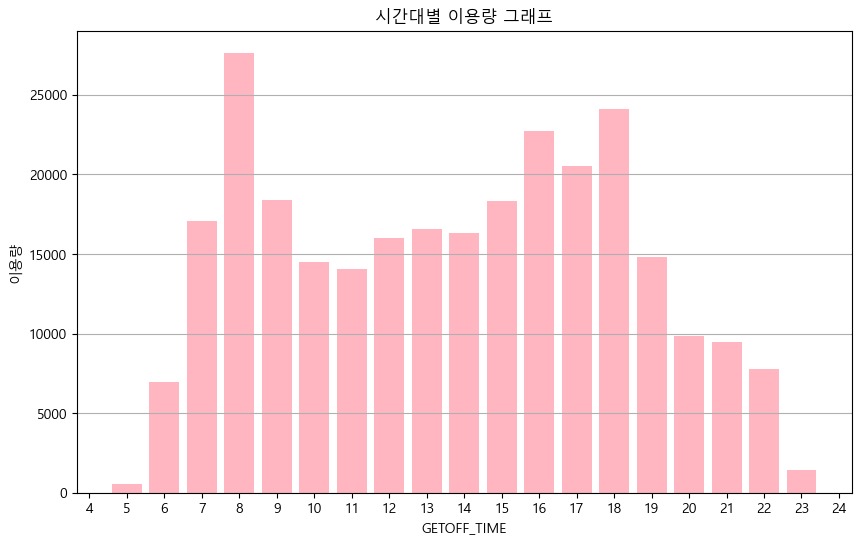

In [34]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# GETON_TIME별 이용량 계산
getoff_time_counts = df_0425['GETOFF_TIME'].value_counts().sort_index()

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.bar(getoff_time_counts.index, getoff_time_counts.values, color='lightpink')
plt.xlabel('GETOFF_TIME')
plt.ylabel('이용량')
plt.title('시간대별 이용량 그래프')

# x축 눈금을 정수로 표시하기 위한 설정
plt.gca().xaxis.set_major_locator(MultipleLocator(base=1))

plt.xticks(rotation=0)
plt.grid(True, axis = 'y')
plt.show()


## 4월 25일 7시

In [23]:
df_0425_07 = df_0425[df_0425['GETON_TIME']==7]
df_0425_07.drop(labels= ['TRANSACTION_ID', 'TR_MEANS_TYPE','USR_TYPE','YSR_CNT','GETON_PAY','GETOFF_PAY','GETON_TIME'], axis = 1, inplace = True)
df_0425_07 = df_0425_07[['CARD_NO','BUS_ROUTE_ID','BUS_CO_ID','BUS_CAR_ID','TRANSF_CNT','GETON_BUS_STTN_ID','GETON_DATETIME','GETOFF_BUS_STTN_ID','GETOFF_DATETIME']]
df_0425_07.head(3)

,CARD_NO,BUS_ROUTE_ID,BUS_CO_ID,BUS_CAR_ID,TRANSF_CNT,GETON_BUS_STTN_ID,GETON_DATETIME,GETOFF_BUS_STTN_ID,GETOFF_DATETIME
169540,661607970,30300070,130010004,130752603,0,8002794,2022-04-25 07:53:58,8002155,2022-04-25 08:16:20
169808,400199826,30300071,130010009,130759102,0,8002897,2022-04-25 07:17:04,8001078,2022-04-25 07:29:10
169820,742469853,30300055,130010014,130753512,0,8001500,2022-04-25 07:44:48,8002488,2022-04-25 08:01:41


In [24]:
# 환승한 경우 제거
transf_counts = [3, 2, 1]

for count in transf_counts:
    card_nos_to_remove = df_0425_07[df_0425_07['TRANSF_CNT'] == count]['CARD_NO']
    df_0425_07 = df_0425_07[~df_0425_07['CARD_NO'].isin(card_nos_to_remove)]

In [46]:
# 102번 버스만 필터링
df_0425_07_30300037 = df_0425_07[df_0425_07['BUS_ROUTE_ID']==30300037]
df_0425_07_30300037.drop(labels = ['BUS_ROUTE_ID', 'BUS_CO_ID','TRANSF_CNT'], axis = 1, inplace = True)

In [47]:
df_0425_07_30300037['GETOFF_BUS_STTN_ID'] = df_0425_07_30300037['GETOFF_BUS_STTN_ID'].astype(int)
df_0425_07_30300037 = df_0425_07_30300037.merge(bus_sttn, left_on = 'GETON_BUS_STTN_ID', right_on = 'bus_sttn_id').merge(bus_sttn, left_on = 'GETOFF_BUS_STTN_ID', right_on = 'bus_sttn_id')
df_0425_07_30300037 = df_0425_07_30300037[['CARD_NO','BUS_CAR_ID','bus_sttn_nm_x','GETON_BUS_STTN_ID','posx_x','posy_x','GETON_DATETIME','bus_sttn_nm_y','GETOFF_BUS_STTN_ID','posx_y','posy_y','GETOFF_DATETIME']]
df_0425_07_30300037.columns = ['CARD_NO','BUS_CAR_ID','GETON_BUS_STTN_NM','GETON_BUS_STTN_ID','GETON_POSX','GETON_POSY','GETON_DATETIME','GETOFF_BUS_STTN_NM','GETOFF_BUS_STTN_ID','GETOFF_POSX','GETOFF_POSY','GETOFF_DATETIME']
df_0425_07_30300037.head()

,CARD_NO,BUS_CAR_ID,GETON_BUS_STTN_NM,GETON_BUS_STTN_ID,GETON_POSX,GETON_POSY,GETON_DATETIME,GETOFF_BUS_STTN_NM,GETOFF_BUS_STTN_ID,GETOFF_POSX,GETOFF_POSY,GETOFF_DATETIME
0,742946513,130752044,수정타운아파트,8002075,36.357666,127.397480,2022-04-25 07:14:00,유림공원,8005921,36.359795,127.35469,2022-04-25 07:25:18
1,788390459,130752044,수정타운아파트,8002075,36.357666,127.397480,2022-04-25 07:10:53,유림공원,8005921,36.359795,127.35469,2022-04-25 07:24:57
2,722876167,130752014,증산도교육문화회관,8002658,36.359110,127.424904,2022-04-25 07:24:54,유림공원,8005921,36.359795,127.35469,2022-04-25 07:44:22
3,739976627,130752050,증산도교육문화회관,8002658,36.359110,127.424904,2022-04-25 07:58:32,유림공원,8005921,36.359795,127.35469,2022-04-25 08:23:11
4,785100983,130752011,신동아아파트,8002100,36.358517,127.412420,2022-04-25 07:21:05,유림공원,8005921,36.359795,127.35469,2022-04-25 07:36:26


In [57]:
df_0425_07_130752035 = df_0425_07_30300037[df_0425_07_30300037['BUS_CAR_ID']==130752035]
df_0425_07_130752035.head(3)

,CARD_NO,BUS_CAR_ID,GETON_BUS_STTN_NM,GETON_BUS_STTN_ID,GETON_POSX,GETON_POSY,GETON_DATETIME,GETOFF_BUS_STTN_NM,GETOFF_BUS_STTN_ID,GETOFF_POSX,GETOFF_POSY,GETOFF_DATETIME
171,756625941,130752035,유성시외버스정류장,8002402,36.355476,127.334816,2022-04-25 07:36:24,오정농수산물시장,8002235,36.357296,127.407845,2022-04-25 08:04:18
191,644958656,130752035,덕명동하우스토리,8002141,36.358380,127.304085,2022-04-25 07:29:06,현충원역,8002973,36.359350,127.321710,2022-04-25 07:31:56
193,908317269,130752035,덕명동하우스토리,8002141,36.358380,127.304085,2022-04-25 07:29:04,현충원역,8002973,36.359350,127.321710,2022-04-25 07:32:05


In [109]:
import pydeck as pdk

route_30300037 = getstationbyrouteall[getstationbyrouteall['ROUTE_CD']==30300037]

# 102번 버스 노선 시각화
layer_30300037 = pdk.Layer(
    "ScatterplotLayer",
    data=route_30300037,
    get_position=["GPS_LONG", "GPS_LATI"],
    get_color=[255, 255, 0, 100],  # 빨간색 (RGB 및 투명도)
    get_radius=100,
    pickable=True,
)

# ArcLayer 데이터 생성
arc_data = []
for index, row in df_0425_07_130752035.iterrows():
    arc_data.append({
        'sourcePosition': [row['GETON_POSY'], row['GETON_POSX']],
        'targetPosition': [row['GETOFF_POSY'], row['GETOFF_POSX']],
        'width': 3  # Arc 너비 설정 (임의로 크기 조절)
    })

BLUE_RGB = [0, 0, 255, 200]
RED_RGB = [255, 0, 0, 200]

# ArcLayer 생성
arc_layer = pdk.Layer(
    'ArcLayer',
    data=arc_data,
    get_source_position='sourcePosition',
    get_target_position='targetPosition',
    get_width='width',
    get_tilt=15,
    get_source_color=BLUE_RGB,
    get_target_color=RED_RGB,
    pickable=True,
    auto_highlight=True
)

# PyDeck 맵 생성
view_state = pdk.ViewState(latitude=36.355, longitude=127.355, zoom=12)
deck = pdk.Deck(layers=[arc_layer,layer_30300037], initial_view_state=view_state)

In [110]:
deck

{
  "initialViewState": {
    "latitude": 36.355,
    "longitude": 127.355,
    "zoom": 12
  },
  "layers": [
    {
      "@@type": "ArcLayer",
      "autoHighlight": true,
      "data": [
        {
          "sourcePosition": [
            127.334816,
            36.355476
          ],
          "targetPosition": [
            127.407845,
            36.357296
          ],
          "width": 3
        },
        {
          "sourcePosition": [
            127.304085,
            36.35838
          ],
          "targetPosition": [
            127.32171,
            36.35935
          ],
          "width": 3
        },
        {
          "sourcePosition": [
            127.304085,
            36.35838
          ],
          "targetPosition": [
            127.32171,
            36.35935
          ],
          "width": 3
        },
        {
          "sourcePosition": [
            127.304085,
            36.35838
          ],
          "targetPosition": [
            127.32171,
            36.35935
          ],
          "width": 3
        },
        {
          "sourcePosition": [
            127.304085,
            36.35838
          ],
          "targetPosition": [
            127.32171,
            36.35935
          ],
          "width": 3
        },
        {
          "sourcePosition": [
            127.29754,
            36.350742
          ],
          "targetPosition": [
            127.32171,
            36.35935
          ],
          "width": 3
        },
        {
          "sourcePosition": [
            127.304085,
            36.35838
          ],
          "targetPosition": [
            127.440475,
            36.350216
          ],
          "width": 3
        },
        {
          "sourcePosition": [
            127.36717,
            36.35771
          ],
          "targetPosition": [
            127.440475,
            36.350216
          ],
          "width": 3
        },
        {
          "sourcePosition": [
            127.37318,
            36.35751
          ],
          "targetPosition": [
            127.440475,
            36.350216
          ],
          "width": 3
        },
        {
          "sourcePosition": [
            127.29619,
            36.34805
          ],
          "targetPosition": [
            127.440475,
            36.350216
          ],
          "width": 3
        },
        {
          "sourcePosition": [
            127.39334,
            36.357403
          ],
          "targetPosition": [
            127.440475,
            36.350216
          ],
          "width": 3
        },
        {
          "sourcePosition": [
            127.37318,
            36.35751
          ],
          "targetPosition": [
            127.43719,
            36.34904
          ],
          "width": 3
        },
        {
          "sourcePosition": [
            127.34468,
            36.361355
          ],
          "targetPosition": [
            127.43719,
            36.34904
          ],
          "width": 3
        },
        {
          "sourcePosition": [
            127.34342,
            36.358105
          ],
          "targetPosition": [
            127.43719,
            36.34904
          ],
          "width": 3
        },
        {
          "sourcePosition": [
            127.39595,
            36.357365
          ],
          "targetPosition": [
            127.43719,
            36.34904
          ],
          "width": 3
        },
        {
          "sourcePosition": [
            127.39595,
            36.357365
          ],
          "targetPosition": [
            127.43719,
            36.34904
          ],
          "width": 3
        },
        {
          "sourcePosition": [
            127.35449,
            36.359398
          ],
          "targetPosition": [
            127.43032,
            36.358845
          ],
          "width": 3
        },
        {
          "sourcePosition": [
            127.36717,
            36.35771
          ],
          "targ

## 4월 25일 출근시간대 (7시,8시,9시)

In [97]:
# 출근시간대만 추출
start_time = [7,8,9]
df_0425_start = df_0425[df_0425['GETON_TIME'].isin(start_time)]
df_0425_start.drop(labels= ['TRANSACTION_ID', 'TR_MEANS_TYPE','USR_TYPE','YSR_CNT','GETON_PAY','GETOFF_PAY','GETON_TIME'], axis = 1, inplace = True)
df_0425_start = df_0425_start[['CARD_NO','BUS_ROUTE_ID','BUS_CO_ID','BUS_CAR_ID','TRANSF_CNT','GETON_BUS_STTN_ID','GETON_DATETIME','GETOFF_BUS_STTN_ID','GETOFF_DATETIME']]
df_0425_start.head(3)

,CARD_NO,BUS_ROUTE_ID,BUS_CO_ID,BUS_CAR_ID,TRANSF_CNT,GETON_BUS_STTN_ID,GETON_DATETIME,GETOFF_BUS_STTN_ID,GETOFF_DATETIME
169540,661607970,30300070,130010004,130752603,0,8002794,2022-04-25 07:53:58,8002155,2022-04-25 08:16:20
169541,706749254,30300079,130010009,130759123,0,8001721,2022-04-25 08:07:51,8002802,2022-04-25 08:39:44
169545,771903902,30300037,130010006,130752044,0,8001590,2022-04-25 08:37:12,8002997,2022-04-25 08:42:02


In [99]:
# 환승한 경우 제거
transf_counts = [3, 2, 1]

for count in transf_counts:
    card_nos_to_remove = df_0425_start[df_0425_start['TRANSF_CNT'] == count]['CARD_NO']
    df_0425_start = df_0425_start[~df_0425_start['CARD_NO'].isin(card_nos_to_remove)]

In [100]:
# 102번 버스만 필터링
df_0425_start_30300037 = df_0425_start[df_0425_start['BUS_ROUTE_ID']==30300037]
df_0425_start_30300037.drop(labels = ['BUS_ROUTE_ID', 'BUS_CO_ID','TRANSF_CNT'], axis = 1, inplace = True)

In [101]:
df_0425_start_30300037['GETOFF_BUS_STTN_ID'] = df_0425_start_30300037['GETOFF_BUS_STTN_ID'].astype(int)
df_0425_start_30300037 = df_0425_start_30300037.merge(bus_sttn, left_on = 'GETON_BUS_STTN_ID', right_on = 'bus_sttn_id').merge(bus_sttn, left_on = 'GETOFF_BUS_STTN_ID', right_on = 'bus_sttn_id')
df_0425_start_30300037 = df_0425_start_30300037[['CARD_NO','BUS_CAR_ID','bus_sttn_nm_x','GETON_BUS_STTN_ID','posx_x','posy_x','GETON_DATETIME','bus_sttn_nm_y','GETOFF_BUS_STTN_ID','posx_y','posy_y','GETOFF_DATETIME']]
df_0425_start_30300037.columns = ['CARD_NO','BUS_CAR_ID','GETON_BUS_STTN_NM','GETON_BUS_STTN_ID','GETON_POSX','GETON_POSY','GETON_DATETIME','GETOFF_BUS_STTN_NM','GETOFF_BUS_STTN_ID','GETOFF_POSX','GETOFF_POSY','GETOFF_DATETIME']
df_0425_start_30300037.head()

,CARD_NO,BUS_CAR_ID,GETON_BUS_STTN_NM,GETON_BUS_STTN_ID,GETON_POSX,GETON_POSY,GETON_DATETIME,GETOFF_BUS_STTN_NM,GETOFF_BUS_STTN_ID,GETOFF_POSX,GETOFF_POSY,GETOFF_DATETIME
0,771903902,130752044,봉명동우체국,8001590,36.354650,127.338120,2022-04-25 08:37:12,온천교,8002997,36.358105,127.34342,2022-04-25 08:42:02
1,753182732,130752050,봉명동우체국,8001590,36.354650,127.338120,2022-04-25 09:42:47,온천교,8002997,36.358105,127.34342,2022-04-25 09:47:15
2,531716654,130752035,유성온천역7번출구,8002412,36.354378,127.342026,2022-04-25 07:40:25,온천교,8002997,36.358105,127.34342,2022-04-25 07:41:23
3,534672389,130752050,유성시외버스정류장,8002402,36.355476,127.334816,2022-04-25 09:40:45,온천교,8002997,36.358105,127.34342,2022-04-25 09:47:58
4,753013354,130752050,한밭대학교,8002920,36.350742,127.297540,2022-04-25 09:27:44,온천교,8002997,36.358105,127.34342,2022-04-25 09:48:14


In [102]:
df_0425_start_130752035 = df_0425_start_30300037[df_0425_start_30300037['BUS_CAR_ID']==130752035]
df_0425_start_130752035.head(3)

,CARD_NO,BUS_CAR_ID,GETON_BUS_STTN_NM,GETON_BUS_STTN_ID,GETON_POSX,GETON_POSY,GETON_DATETIME,GETOFF_BUS_STTN_NM,GETOFF_BUS_STTN_ID,GETOFF_POSX,GETOFF_POSY,GETOFF_DATETIME
2,531716654,130752035,유성온천역7번출구,8002412,36.354378,127.342026,2022-04-25 07:40:25,온천교,8002997,36.358105,127.34342,2022-04-25 07:41:23
5,532545772,130752035,한밭대학교,8002920,36.350742,127.297540,2022-04-25 07:27:29,온천교,8002997,36.358105,127.34342,2022-04-25 07:41:20
15,742909007,130752035,홈플러스유성점,8002984,36.359398,127.354490,2022-04-25 07:47:07,중리네거리,8002607,36.358845,127.43032,2022-04-25 08:10:53


In [105]:
df_0425_start_30300037

,CARD_NO,BUS_CAR_ID,GETON_BUS_STTN_NM,GETON_BUS_STTN_ID,GETON_POSX,GETON_POSY,GETON_DATETIME,GETOFF_BUS_STTN_NM,GETOFF_BUS_STTN_ID,GETOFF_POSX,GETOFF_POSY,GETOFF_DATETIME
0,771903902,130752044,봉명동우체국,8001590,36.354650,127.338120,2022-04-25 08:37:12,온천교,8002997,36.358105,127.34342,2022-04-25 08:42:02
1,753182732,130752050,봉명동우체국,8001590,36.354650,127.338120,2022-04-25 09:42:47,온천교,8002997,36.358105,127.34342,2022-04-25 09:47:15
2,531716654,130752035,유성온천역7번출구,8002412,36.354378,127.342026,2022-04-25 07:40:25,온천교,8002997,36.358105,127.34342,2022-04-25 07:41:23
3,534672389,130752050,유성시외버스정류장,8002402,36.355476,127.334816,2022-04-25 09:40:45,온천교,8002997,36.358105,127.34342,2022-04-25 09:47:58
4,753013354,130752050,한밭대학교,8002920,36.350742,127.297540,2022-04-25 09:27:44,온천교,8002997,36.358105,127.34342,2022-04-25 09:48:14
...,...,...,...,...,...,...,...,...,...,...,...,...
1833,279831502,130752039,용전초등학교입구,8002312,36.355015,127.432930,2022-04-25 09:07:35,중리지구대,8002617,36.358982,127.42110,2022-04-25 09:14:32
1834,761738438,130752024,용전초등학교입구,8002312,36.355015,127.432930,2022-04-25 08:52:48,중리지구대,8002617,36.358982,127.42110,2022-04-25 08:58:33
1835,699608006,130752005,수통골삼거리,8003003,36.348050,127.296190,2022-04-25 08:25:10,주유소,8002589,36.359062,127.30973,2022-04-25 08:31:46
1836,730898733,130759012,이스트시티아파트,8002155,36.328053,127.439354,2022-04-25 08:22:36,대동역2번출구,8005881,36.328777,127.44132,2022-04-25 08:22:56


In [106]:
import pydeck as pdk

route_30300037 = getstationbyrouteall[getstationbyrouteall['ROUTE_CD']==30300037]

# 102번 버스 노선 시각화
layer_30300037 = pdk.Layer(
    "ScatterplotLayer",
    data=route_30300037,
    get_position=["GPS_LONG", "GPS_LATI"],
    get_color=[255, 255, 0, 100],  # 빨간색 (RGB 및 투명도)
    get_radius=100,
    pickable=True,
)

# ArcLayer 데이터 생성
arc_data = []
for index, row in df_0425_start_30300037.iterrows():
    arc_data.append({
        'sourcePosition': [row['GETON_POSY'], row['GETON_POSX']],
        'targetPosition': [row['GETOFF_POSY'], row['GETOFF_POSX']],
        'width': 3  # Arc 너비 설정 (임의로 크기 조절)
    })

BLUE_RGB = [0, 0, 255, 200]
RED_RGB = [255, 0, 0, 200]

# ArcLayer 생성
arc_layer = pdk.Layer(
    'ArcLayer',
    data=arc_data,
    get_source_position='sourcePosition',
    get_target_position='targetPosition',
    get_width='width',
    get_tilt=15,
    get_source_color=BLUE_RGB,
    get_target_color=RED_RGB,
    pickable=True,
    auto_highlight=True
)

# PyDeck 맵 생성
view_state = pdk.ViewState(latitude=36.355, longitude=127.355, zoom=12)
deck = pdk.Deck(layers=[arc_layer,layer_30300037], initial_view_state=view_state)

In [108]:
df_0425_start_30300037['BUS_CAR_ID'].value_counts()

BUS_CAR_ID
130752035    84
130752053    76
130752037    74
130752024    73
130759027    69
130752049    68
130752007    68
130759004    65
130752027    63
130752046    63
130752072    61
130752031    61
130752038    60
130752014    60
130752040    60
130752039    59
130752044    58
130752045    57
130759023    56
130752074    56
130752073    55
130759012    52
130759016    51
130759011    51
130752002    51
130759024    47
130752011    46
130752050    44
130752062    41
130752005    38
130759021    36
130759017    35
Name: count, dtype: int64